# **Configuration and Imports**

In [1]:
from google.colab import auth
auth.authenticate_user()

In [15]:
import bigframes as bf
import bigframes.pandas as bpd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.cloud import bigquery
import pandas as pd

project_id = "reliable-jet-452114-s2"

client = bigquery.Client(project=project_id)

# **Datasets**
The datasets used in these project were the ones we considered most relevant for the task at hand.

They were uploaded to the BigQuery project `reliable-jet-452114 s-2` via Google Cloud Storage.

Below we perform some queries to vizualize and ensure data quality in all of these the datasets.


## **Chartevents Reduced**
Contains time-stamped clinical data and measurements recorded for patients during their hospital stay.

-   `ROW_ID`: Unique identifier for the row.
-   `SUBJECT_ID`: Foreign key to the PATIENTS table.
-   `HADM_ID`: Foreign key to the ADMISSIONS table.
-   `ITEMID`: Foreign key to the D_ITEMS table, indicating the type of measurement.
-   `CHARTTIME`: Timestamp when the measurement was recorded.
-   `STORETIME`: Timestamp when the measurement was stored.
-   `VALUE`: The value of the measurement (can be numeric or text).
-   `VALUENUM`: Numeric value of the measurement, if applicable.
-   `VALUEUOM`: Unit of measurement.
-   `WARNING`: Flags indicating potential issues with the data.


### **Reducing the original Chartevents dataset**

We decided to create a more small and acessible table using the original `chartevents`. This new table, `chartevents_reduced`, that will be used from now on, only contains the measurements of the most common disease in the original table.

To do this, we used a query to perform the following steps:
1. Create the table `chartevents_reduced`
2. Identify the disease related measurements
3. Find the most common disease
4. Store the measurements of the most common disease in the new table

In [ ]:
query = """
-- Step 1: Create a new table for disease-related data
CREATE OR REPLACE TABLE `reliable-jet-452114-s2.table.chartevents_reduced` AS

-- Step 2: Identify and select only disease-related measurements
WITH disease_measurements AS (
  SELECT *
  FROM `reliable-jet-452114-s2.table.chartevents`
  WHERE ITEMID IN (
    -- Cardiovascular
    220045,  -- Heart Rate
    220050,  -- Blood Pressure Systolic
    220051,  -- Blood Pressure Diastolic

    -- Metabolic/Endocrine
    220179,  -- Glucose
    50912,   -- Creatinine
    50809,   -- Glucose (serum)

    -- Respiratory
    220277,  -- SpO2
    224690,  -- Respiratory Rate

    -- Infection/Inflammation
    50813,   -- Lactate (sepsis marker)

    -- Liver
    50821    -- Bilirubin
  )
),

-- Step 3: Find the top 3 most common disease measurements
top_disease_measurements AS (
  SELECT
    ITEMID,
    COUNT(*) AS measurement_count
  FROM disease_measurements
  GROUP BY ITEMID
  ORDER BY measurement_count DESC
  LIMIT 3
)

-- Step 4: Create final table with only top disease measurements
SELECT d.*
FROM disease_measurements d
JOIN top_disease_measurements t ON d.ITEMID = t.ITEMID;
"""

query_job = client.query(query)
print("Dataset reduced sucessfully")

Dataset reduced sucessfully


### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "chartevents_reduced"

table_ref = client.dataset(dataset_id).table(table_id)

chartevents = client.list_rows(table_ref).to_dataframe()

chartevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,23505201,76698,172378,279571,220179,2165-03-16 13:00:00+00:00,2165-03-16 20:23:00+00:00,14992,-69,-69.0,mmHg,0,0,None,None
1,19184847,66298,152072,200105,220045,2104-10-24 00:05:00+00:00,NaT,<NA>,0,0.0,bpm,0,0,None,None
2,19184616,66298,152072,200105,220045,2104-10-23 23:54:00+00:00,NaT,<NA>,0,0.0,bpm,0,0,None,None
3,28452063,87253,172278,200231,220045,2127-03-14 17:15:00+00:00,2127-03-14 18:25:00+00:00,15412,0,0.0,bpm,0,0,None,None
4,8729221,46330,125187,200756,220045,2153-01-29 21:31:00+00:00,2153-01-29 22:35:00+00:00,17950,0,0.0,bpm,0,0,None,None


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for chartevents_reduced
WITH stats AS (
  SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
    COUNT(DISTINCT HADM_ID) AS unique_admissions,
    COUNT(DISTINCT ITEMID) AS unique_measurement_types
  FROM `reliable-jet-452114-s2.table.chartevents_reduced`
),

measurement_analysis AS (
  SELECT
    ITEMID,
    COUNT(*) AS record_count,
    ROUND(COUNT(*)*100/(SELECT total_records FROM stats), 2) AS percentage_of_total,
    MIN(VALUENUM) AS min_value,
    MAX(VALUENUM) AS max_value,
    AVG(VALUENUM) AS avg_value,
    COUNT(CASE WHEN VALUENUM IS NULL THEN 1 END) AS null_value_counts,
    COUNT(CASE WHEN VALUE = '' THEN 1 END) AS empty_string_counts,
    MIN(CHARTTIME) AS earliest_measurement,
    MAX(CHARTTIME) AS latest_measurement
  FROM `reliable-jet-452114-s2.table.chartevents_reduced`
  GROUP BY ITEMID
),

temporal_analysis AS (
  SELECT
    EXTRACT(YEAR FROM CHARTTIME) AS year,
    EXTRACT(MONTH FROM CHARTTIME) AS month,
    COUNT(*) AS measurements_count
  FROM `reliable-jet-452114-s2.table.chartevents_reduced`
  GROUP BY year, month
  ORDER BY year, month
)

SELECT
  -- Basic Statistics
  s.total_records,
  s.unique_patients,
  s.unique_admissions,
  s.unique_measurement_types,

  -- Measurement-specific quality metrics
  ARRAY(
    SELECT AS STRUCT * FROM measurement_analysis
    ORDER BY record_count DESC
  ) AS measurement_quality,

  -- Temporal distribution
  (SELECT COUNT(*) FROM temporal_analysis) AS months_with_data,
  (SELECT MIN(year) FROM temporal_analysis) AS first_year,
  (SELECT MAX(year) FROM temporal_analysis) AS last_year,

  -- Data completeness
  (SELECT COUNT(*) FROM `reliable-jet-452114-s2.table.chartevents_reduced` WHERE CHARTTIME IS NULL) AS null_timestamps,
  (SELECT COUNT(*) FROM `reliable-jet-452114-s2.table.chartevents_reduced` WHERE SUBJECT_ID IS NULL) AS null_patient_ids,

  -- Clinical validity checks
  (SELECT COUNT(*) FROM `reliable-jet-452114-s2.table.chartevents_reduced`
   WHERE ITEMID = 220045 AND (VALUENUM < 20 OR VALUENUM > 250)) AS abnormal_heart_rates,

  (SELECT COUNT(*) FROM `reliable-jet-452114-s2.table.chartevents_reduced`
   WHERE ITEMID = 220050 AND (VALUENUM < 50 OR VALUENUM > 300)) AS abnormal_bp_readings
FROM stats s
"""

query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_patients,unique_admissions,unique_measurement_types,measurement_quality,months_with_data,first_year,last_year,null_timestamps,null_patient_ids,abnormal_heart_rates,abnormal_bp_readings
0,6724529,17717,21927,3,"[{'ITEMID': 220045, 'record_count': 2762225, '...",1289,2100,2209,0,0,1177,0


## **Admissions**
Contains information about patient admissions to the hospital, such as admission and discharge times, admission type, and insurance information.

-   `ROW_ID`: Unique identifier for each row
-   `SUBJECT_ID`: Foreign key to the PATIENTS table.
-   `HADM_ID`: Unique identifier for the hospital admission
-   `ADMITTIME`: Timestamp for hospital admission.
-   `DISCHTIME`: Timestamp for hospital discharge.
-   `DEATHTIME`: Timestamp for patient death, if applicable.
-   `ADMISSION_TYPE`: Type of admission, e.g., EMERGENCY, ELECTIVE, URGENT.
-   `ADMISSION_LOCATION`: Location of the patient prior to admission.
-   `DISCHARGE_LOCATION`: Location to which the patient was discharged.
-   `INSURANCE`: The patient's insurance provider.
-   `LANGUAGE`: The patient's primary language.
-   `RELIGION`: The patient's religious affiliation.
-   `MARITAL_STATUS`: The patient's marital status.
-   `ETHNICITY`: The patient's ethnicity.
-   `EDREGTIME`: Emergency Department registration time
-   `EDOUTTIME`: Emergency Department departure time
-   `DIAGNOSIS`: The patient's primary diagnosis.
-   `HOSPITAL_EXPIRE_FLAG`: Indicates if the patient died in the hospital.
-   `HAS_CHARTEVENTS_DATA`: Flag indicating if there is chart event data.

### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "admissions"

table_ref = client.dataset(dataset_id).table(table_id)

admissions = client.list_rows(table_ref).to_dataframe()

admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,4060,3369,126808,2111-01-24 11:53:00+00:00,2111-01-25 22:40:00+00:00,2111-01-25 22:40:00+00:00,EMERGENCY,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Private,None,UNOBTAINABLE,SINGLE,WHITE,NaT,NaT,None,1,1
1,50952,74869,123152,2150-09-05 17:49:00+00:00,2150-09-12 18:30:00+00:00,2150-09-12 18:30:00+00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,WIDOWED,ASIAN - JAPANESE,NaT,NaT,? SEROTONIN SYNDROME,1,1
2,12812,10484,113233,2190-09-18 22:39:00+00:00,2190-09-24 20:40:00+00:00,2190-09-24 20:40:00+00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicaid,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,(AML) ACUTE MYELOGENOUS LEUKEMIA,1,1
3,13573,11091,164694,2101-06-07 13:57:00+00:00,2101-09-18 07:20:00+00:00,2101-09-18 07:20:00+00:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,None,CATHOLIC,SEPARATED,WHITE,NaT,NaT,(AML) ACUTE MYELOGENOUS LEUKEMIA,1,1
4,33654,27527,155091,2131-08-27 18:01:00+00:00,2131-10-03 05:30:00+00:00,2131-10-03 05:30:00+00:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,PTUN,NOT SPECIFIED,MARRIED,WHITE,NaT,NaT,(AML) ACUTE MYELOGENOUS LEUKEMIA,1,1


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for admissions
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT HADM_ID) AS unique_admissions,
    COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
    COUNT(CASE WHEN ADMITTIME IS NULL THEN 1 END) AS null_admit_times,
    COUNT(CASE WHEN DISCHTIME IS NULL THEN 1 END) AS null_discharge_times,
    COUNT(CASE WHEN ADMISSION_TYPE IS NULL THEN 1 END) AS null_admission_types,
    COUNT(CASE WHEN ADMISSION_LOCATION IS NULL THEN 1 END) AS null_admission_locations,
    COUNT(CASE WHEN INSURANCE IS NULL THEN 1 END) AS null_insurance_info,
    MIN(ADMITTIME) AS first_admission,
    MAX(ADMITTIME) AS last_admission
FROM `reliable-jet-452114-s2.table.admissions`;
"""

query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_admissions,unique_patients,null_admit_times,null_discharge_times,null_admission_types,null_admission_locations,null_insurance_info,first_admission,last_admission
0,58976,58976,46520,0,0,0,0,0,2100-06-07 19:59:00+00:00,2210-08-17 17:13:00+00:00


## **Callout**

Contains information about requests for services or consultations for patients.

-   `ROW_ID`: Unique identifier for the row.
-   `SUBJECT_ID`: Foreign key to the PATIENTS table.
-   `HADM_ID`: Foreign key to the ADMISSIONS table.
-   `CALLOUT_ID`: Unique identifier for the callout request.
-   `CALLOUTTIME`: Timestamp for the callout request.
-   `SERVICE_ID`: ID of the service requested.
-   `LOCATION`: Location of the patient when the callout was placed.
-   `STATUS`: Status of the callout request.
-   `OUTCOME`: Outcome of the callout request.
-   `ACKNOWLEDGE_TIME`: Timestamp when the callout was acknowledged.
-   `OUTCOMETIME`: Timestamp when the callout outcome was recorded.
-   `FIRSTRESERVATIONTIME`:  of the first reservation.
-   `CURRENTRESERVATIONTIME`: Timestamp of the current reservation.
-   `CREATETIME`: Timestamp when the row was created.
-   `UPDATETIME`: Timestamp when the row was updated.
-   `CALLOUT_WARDID`: Ward ID of the callout.
-   `CALLOUT_SERVICEREQUEST`: Service requested.
-   `CALLOUT_TELEPHONE`: Telephone number for the callout.
-    `REQUEST_TELE`: Telephone request.
-    `REQUEST_RESP`: Respiratory reqTimestampuest.
-   `REQUEST_CDIFF`: C. difficile request.
-   `REQUEST_MRSA`: MRSA request.
-   `REQUEST_VRE`: VRE request.
-   `DISCHARGE_WARDID`: Discharge ward ID.
-   `ACKNOWLEDGE_STATUS`: Acknowledge status.

### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "callout"

table_ref = client.dataset(dataset_id).table(table_id)

callout = client.list_rows(table_ref).to_dataframe()

callout.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SUBMIT_WARDID,SUBMIT_CAREUNIT,CURR_WARDID,CURR_CAREUNIT,CALLOUT_WARDID,CALLOUT_SERVICE,REQUEST_TELE,...,CALLOUT_STATUS,CALLOUT_OUTCOME,DISCHARGE_WARDID,ACKNOWLEDGE_STATUS,CREATETIME,UPDATETIME,ACKNOWLEDGETIME,OUTCOMETIME,FIRSTRESERVATIONTIME,CURRENTRESERVATIONTIME
0,15115,31974,144780,<NA>,None,<NA>,None,1,MED,1,...,Inactive,Discharged,0,Unacknowledged,2191-01-26 13:55:10+00:00,2191-01-26 13:55:10+00:00,NaT,2191-01-26 14:10:04+00:00,NaT,NaT
1,161,309,162308,7,None,2,CCU,2,CCU,1,...,Inactive,Discharged,2,Acknowledged,2160-06-05 10:22:04+00:00,2160-06-05 10:22:04+00:00,2160-06-05 11:20:06+00:00,2160-06-05 19:25:01+00:00,NaT,NaT
2,169,333,160548,7,None,2,CCU,2,CCU,1,...,Inactive,Discharged,2,Acknowledged,2137-09-30 09:42:12+00:00,2137-09-30 09:42:12+00:00,2137-09-30 09:45:08+00:00,2137-10-01 14:40:02+00:00,NaT,NaT
3,197,383,173723,7,None,2,CCU,2,CCU,1,...,Inactive,Discharged,2,Unacknowledged,2143-09-08 10:53:04+00:00,2143-09-08 10:53:04+00:00,NaT,2143-09-08 11:55:02+00:00,NaT,NaT
4,136,253,176189,7,None,2,CCU,2,CCU,1,...,Inactive,Discharged,2,Acknowledged,2174-01-23 09:57:24+00:00,2174-01-23 10:44:12+00:00,2174-01-23 11:10:50+00:00,2174-01-23 13:40:02+00:00,NaT,NaT


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for callout
WITH basic_stats AS (
    SELECT
        COUNT(*) AS total_records,
        COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
        COUNT(DISTINCT HADM_ID) AS unique_admissions,
        COUNT(DISTINCT ROW_ID) AS unique_row_ids,
        COUNT(DISTINCT SUBMIT_WARDID) AS unique_submit_ward_ids,
        COUNT(DISTINCT SUBMIT_CAREUNIT) AS unique_submit_care_units,
        COUNT(DISTINCT CURR_WARDID) AS unique_current_ward_ids,
        COUNT(DISTINCT CURR_CAREUNIT) AS unique_current_care_units,
        COUNT(DISTINCT CALLOUT_WARDID) AS unique_callout_ward_ids,
        COUNT(DISTINCT CALLOUT_SERVICE) AS unique_callout_service,
        COUNT(DISTINCT REQUEST_TELE) AS unique_request_telephones,
        COUNT(DISTINCT REQUEST_RESP) AS unique_request_resp,
        COUNT(DISTINCT REQUEST_CDIFF) AS unique_request_cdiff,
        COUNT(DISTINCT REQUEST_MRSA) AS unique_request_mrsa,
        COUNT(DISTINCT REQUEST_VRE) AS unique_request_vre,
        COUNT(DISTINCT CALLOUT_STATUS) AS unique_callout_statuses,
        COUNT(DISTINCT CALLOUT_OUTCOME) AS unique_callout_outcomes,
        COUNT(DISTINCT DISCHARGE_WARDID) AS unique_discharge_ward_ids,
        COUNT(DISTINCT ACKNOWLEDGE_STATUS) AS unique_acknowledge_statuses
    FROM `reliable-jet-452114-s2.table.callout`
),
completeness AS (
    SELECT
        COUNT(CASE WHEN SUBJECT_ID IS NULL THEN 1 END) AS null_subject_ids,
        COUNT(CASE WHEN HADM_ID IS NULL THEN 1 END) AS null_hadm_ids,
        COUNT(CASE WHEN SUBMIT_WARDID IS NULL THEN 1 END) AS null_submit_ward_ids,
        COUNT(CASE WHEN SUBMIT_CAREUNIT IS NULL THEN 1 END) AS null_submit_care_units,
        COUNT(CASE WHEN SUBMIT_CAREUNIT = '' THEN 1 END) AS empty_submit_care_units,
        COUNT(CASE WHEN CURR_WARDID IS NULL THEN 1 END) AS null_curr_ward_ids,
        COUNT(CASE WHEN CURR_CAREUNIT IS NULL THEN 1 END) AS null_curr_care_units,
        COUNT(CASE WHEN CURR_CAREUNIT = '' THEN 1 END) AS empty_curr_care_units,
        COUNT(CASE WHEN CALLOUT_WARDID IS NULL THEN 1 END) AS null_callout_ward_ids,
        COUNT(CASE WHEN CALLOUT_SERVICE IS NULL THEN 1 END) AS null_callout_service,
        COUNT(CASE WHEN CALLOUT_SERVICE = '' THEN 1 END) AS empty_callout_service,
        COUNT(CASE WHEN REQUEST_TELE IS NULL THEN 1 END) AS null_request_telephones,
        COUNT(CASE WHEN REQUEST_RESP IS NULL THEN 1 END) AS null_request_resp,
        COUNT(CASE WHEN REQUEST_CDIFF IS NULL THEN 1 END) AS null_request_cdiff,
        COUNT(CASE WHEN REQUEST_MRSA IS NULL THEN 1 END) AS null_request_mrsa,
        COUNT(CASE WHEN REQUEST_VRE IS NULL THEN 1 END) AS null_request_vre,
        COUNT(CASE WHEN CALLOUT_STATUS IS NULL THEN 1 END) AS null_callout_statuses,
        COUNT(CASE WHEN CALLOUT_STATUS = '' THEN 1 END) AS empty_callout_statuses,
        COUNT(CASE WHEN CALLOUT_OUTCOME IS NULL THEN 1 END) AS null_callout_outcomes,
        COUNT(CASE WHEN CALLOUT_OUTCOME = '' THEN 1 END) AS empty_callout_outcomes,
        COUNT(CASE WHEN DISCHARGE_WARDID IS NULL THEN 1 END) AS null_discharge_ward_ids,
        COUNT(CASE WHEN ACKNOWLEDGE_STATUS IS NULL THEN 1 END) AS null_acknowledge_statuses,
        COUNT(CASE WHEN ACKNOWLEDGE_STATUS = '' THEN 1 END) AS empty_acknowledge_statuses,
        COUNT(CASE WHEN CREATETIME IS NULL THEN 1 END) AS null_createtimes,
        COUNT(CASE WHEN UPDATETIME IS NULL THEN 1 END) AS null_updatetimes,
        COUNT(CASE WHEN ACKNOWLEDGETIME IS NULL THEN 1 END) AS null_acknowledgetimes,
        COUNT(CASE WHEN OUTCOMETIME IS NULL THEN 1 END) AS null_outcometimes,
        COUNT(CASE WHEN FIRSTRESERVATIONTIME IS NULL THEN 1 END) AS null_firstreservationtimes,
        COUNT(CASE WHEN CURRENTRESERVATIONTIME IS NULL THEN 1 END) AS null_currentreservationtimes
    FROM `reliable-jet-452114-s2.table.callout`
),
temporal_analysis AS (
    SELECT
        MIN(CREATETIME) AS first_creation_time,
        MAX(CREATETIME) AS last_creation_time,
        MIN(UPDATETIME) AS first_update_time,
        MAX(UPDATETIME) AS last_update_time,
        MIN(ACKNOWLEDGETIME) AS first_acknowledge_time,
        MAX(ACKNOWLEDGETIME) AS last_acknowledge_time,
        MIN(OUTCOMETIME) AS first_outcome_time,
        MAX(OUTCOMETIME) AS last_outcome_time,
        MIN(FIRSTRESERVATIONTIME) AS first_reservation_time,
        MAX(FIRSTRESERVATIONTIME) AS last_reservation_time,
        MIN(CURRENTRESERVATIONTIME) AS first_current_reservation_time,
        MAX(CURRENTRESERVATIONTIME) AS last_current_reservation_time
    FROM `reliable-jet-452114-s2.table.callout`
)
SELECT
    bs.*,
    c.*,
    t.*
FROM basic_stats bs
CROSS JOIN completeness c
CROSS JOIN temporal_analysis t;
"""

query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_patients,unique_admissions,unique_row_ids,unique_submit_ward_ids,unique_submit_care_units,unique_current_ward_ids,unique_current_care_units,unique_callout_ward_ids,unique_callout_service,...,first_update_time,last_update_time,first_acknowledge_time,last_acknowledge_time,first_outcome_time,last_outcome_time,first_reservation_time,last_reservation_time,first_current_reservation_time,last_current_reservation_time
0,34499,22871,28732,34499,9,5,35,5,37,21,...,2100-06-08 12:58:29+00:00,2210-08-20 16:05:16+00:00,2100-06-08 12:58:32+00:00,2210-08-20 16:05:27+00:00,2100-06-08 15:10:26+00:00,2210-08-20 18:55:15+00:00,2100-06-08 11:55:26+00:00,2210-08-20 16:25:16+00:00,2100-08-09 14:42:25+00:00,2209-08-05 14:01:23+00:00


## **ICD Diagnoses Description**
Contains descriptions for ICD-9 diagnosis codes.

-   `ROW_ID`: Unique identifier for the row.
-   `ICD9_CODE`: The ICD-9 diagnosis code.
-   `SHORT_TITLE`: Short description of the diagnosis.
-   `LONG_TITLE`: Long description of the diagnosis.

### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "d_icd_diagnoses"

table_ref = client.dataset(dataset_id).table(table_id)

d_icd_diagnoses = client.list_rows(table_ref).to_dataframe()

d_icd_diagnoses.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,5120,4957,"""ventilation"" pneumonit","""Ventilation"" pneumonitis"
1,11159,94416,1 deg burn back of hand,Erythema [first degree] of back of hand
2,11157,94414,1 deg burn fingr w thumb,Erythema [first degree] of two or more digits ...
3,3658,36911,1 eye-sev/oth-blind NOS,Better eye: severe vision impairment; lesser e...
4,12505,94811,10-19% bdy brn/10-19% 3d,Burn [any degree] involving 10-19 percent of b...


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for d_icd_diagnoses
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT ROW_ID) AS unique_row_ids,
    COUNT(DISTINCT ICD9_CODE) AS unique_icd9_codes,
    COUNT(DISTINCT SHORT_TITLE) AS unique_short_titles,
    COUNT(DISTINCT LONG_TITLE) AS unique_long_titles,

    -- Completeness checks
    COUNT(CASE WHEN ROW_ID IS NULL THEN 1 END) AS null_row_ids,
    COUNT(CASE WHEN ICD9_CODE IS NULL THEN 1 END) AS null_icd9_codes,
    COUNT(CASE WHEN SHORT_TITLE IS NULL THEN 1 END) AS null_short_titles,
    COUNT(CASE WHEN LONG_TITLE IS NULL THEN 1 END) AS null_long_titles,

    COUNT(CASE WHEN ICD9_CODE = '' THEN 1 END) AS empty_icd9_codes,
    COUNT(CASE WHEN SHORT_TITLE = '' THEN 1 END) AS empty_short_titles,
    COUNT(CASE WHEN LONG_TITLE = '' THEN 1 END) AS empty_long_titles,

    -- Basic Analysis of ICD9 Code Length (assuming ICD9_CODE is a string)
    AVG(LENGTH(ICD9_CODE)) AS avg_icd9_code_length,
    MIN(LENGTH(ICD9_CODE)) AS min_icd9_code_length,
    MAX(LENGTH(ICD9_CODE)) AS max_icd9_code_length,
    COUNT(CASE WHEN LENGTH(ICD9_CODE) NOT BETWEEN 3 AND 5 THEN 1 END) AS potential_invalid_icd9_length_count,

    -- Examples of potential data inconsistencies (may need refinement based on your data understanding)
    COUNT(CASE WHEN SHORT_TITLE LIKE '%NOS%' AND LONG_TITLE NOT LIKE '%not otherwise specified%' THEN 1 END) AS short_title_nos_long_title_mismatch,
    COUNT(CASE WHEN SHORT_TITLE LIKE '%NEC%' AND LONG_TITLE NOT LIKE '%not elsewhere classified%' THEN 1 END) AS short_title_nec_long_title_mismatch

FROM
    `reliable-jet-452114-s2.table.d_icd_diagnoses`;
"""
query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_row_ids,unique_icd9_codes,unique_short_titles,unique_long_titles,null_row_ids,null_icd9_codes,null_short_titles,null_long_titles,empty_icd9_codes,empty_short_titles,empty_long_titles,avg_icd9_code_length,min_icd9_code_length,max_icd9_code_length,potential_invalid_icd9_length_count,short_title_nos_long_title_mismatch,short_title_nec_long_title_mismatch
0,14567,14567,14567,14328,14562,0,0,0,0,0,0,0,4.686483,3,5,0,2195,2138


## **D Items**
Contains metadata about different medical items (measurements, procedures, medications) recorded in the database.

-   `ROW_ID`: Unique identifier for the row.
-   `ITEMID`: Unique identifier for the item.
-   `LABEL`: Label or name of the item.
-   `ABBREVIATION`: Abbreviation for the item.
-   `DBSOURCE`: Source database for the item.
-   `LINKSTO`: Table linked to.
-   `CATEGORY`: Category of the item.
-   `UNITNAME`: Unit of measurement for the item.
-   `PARAM_TYPE`: Parameter type.
-   `CONCEPTID`: Identifier for the concept.

### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "d_items"

table_ref = client.dataset(dataset_id).table(table_id)

d_items = client.list_rows(table_ref).to_dataframe()

d_items.head()

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
0,457,497,Patient controlled analgesia (PCA) [Inject],None,carevue,chartevents,None,None,None,None
1,458,498,PCA Lockout (Min),None,carevue,chartevents,None,None,None,None
2,459,499,PCA Medication,None,carevue,chartevents,None,None,None,None
3,460,500,PCA Total Dose,None,carevue,chartevents,None,None,None,None
4,461,501,PCV Exh Vt (Obser),None,carevue,chartevents,None,None,None,None


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for d_items
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT ROW_ID) AS unique_row_ids,
    COUNT(DISTINCT ITEMID) AS unique_itemids,
    COUNT(DISTINCT LABEL) AS unique_labels,
    COUNT(DISTINCT ABBREVIATION) AS unique_abbreviations,
    COUNT(DISTINCT DBSOURCE) AS unique_dbsources,
    COUNT(DISTINCT LINKSTO) AS unique_linkstos,
    COUNT(DISTINCT CATEGORY) AS unique_categories,
    COUNT(DISTINCT UNITNAME) AS unique_unitnames,
    COUNT(DISTINCT PARAM_TYPE) AS unique_param_types,
    COUNT(DISTINCT CONCEPTID) AS unique_conceptids,

    -- Completeness checks (NULL values)
    COUNT(CASE WHEN ROW_ID IS NULL THEN 1 END) AS null_row_ids,
    COUNT(CASE WHEN ITEMID IS NULL THEN 1 END) AS null_itemids,
    COUNT(CASE WHEN LABEL IS NULL THEN 1 END) AS null_labels,
    COUNT(CASE WHEN ABBREVIATION IS NULL THEN 1 END) AS null_abbreviations,
    COUNT(CASE WHEN DBSOURCE IS NULL THEN 1 END) AS null_dbsources,
    COUNT(CASE WHEN LINKSTO IS NULL THEN 1 END) AS null_linkstos,
    COUNT(CASE WHEN CATEGORY IS NULL THEN 1 END) AS null_categories,
    COUNT(CASE WHEN UNITNAME IS NULL THEN 1 END) AS null_unitnames,
    COUNT(CASE WHEN PARAM_TYPE IS NULL THEN 1 END) AS null_param_types,
    COUNT(CASE WHEN CONCEPTID IS NULL THEN 1 END) AS null_conceptids,

    -- Completeness checks (Empty strings - assuming string type for these)
    COUNT(CASE WHEN LABEL = '' THEN 1 END) AS empty_labels,
    COUNT(CASE WHEN ABBREVIATION = '' THEN 1 END) AS empty_abbreviations,
    COUNT(CASE WHEN DBSOURCE = '' THEN 1 END) AS empty_dbsources,
    COUNT(CASE WHEN LINKSTO = '' THEN 1 END) AS empty_linkstos,
    COUNT(CASE WHEN CATEGORY = '' THEN 1 END) AS empty_categories,
    COUNT(CASE WHEN UNITNAME = '' THEN 1 END) AS empty_unitnames,
    COUNT(CASE WHEN PARAM_TYPE = '' THEN 1 END) AS empty_param_types,
    COUNT(CASE WHEN CONCEPTID = '' THEN 1 END) AS empty_conceptids

FROM
    `reliable-jet-452114-s2.table.d_items`; -- Replace with your actual table name if different
"""
query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_row_ids,unique_itemids,unique_labels,unique_abbreviations,unique_dbsources,unique_linkstos,unique_categories,unique_unitnames,unique_param_types,...,null_param_types,null_conceptids,empty_labels,empty_abbreviations,empty_dbsources,empty_linkstos,empty_categories,empty_unitnames,empty_param_types,empty_conceptids
0,12487,12487,12487,11847,2907,3,7,94,53,7,...,9495,12487,0,0,0,0,0,0,0,0


## **ICD Diagnoses**
Contains ICD-9 diagnosis codes assigned to patients during their hospital admissions.

-   `ROW_ID`: Unique identifier for the row.
-   `SUBJECT_ID`: Foreign key to the PATIENTS table.
-   `HADM_ID`: Foreign key to the ADMISSIONS table.
-   `SEQ_NUM`: Sequence number for the diagnosis within the admission.
-   `ICD9_CODE`: The ICD-9 diagnosis code.


### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "diagnoses_icd"

table_ref = client.dataset(dataset_id).table(table_id)

diagnoses_icd = client.list_rows(table_ref).to_dataframe()

diagnoses_icd.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1,40301
1,1298,109,172335,2,486
2,1299,109,172335,3,58281
3,1300,109,172335,4,5855
4,1301,109,172335,5,4254


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for diagnoses_icd
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT ROW_ID) AS unique_row_ids,
    COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
    COUNT(DISTINCT HADM_ID) AS unique_admissions,
    COUNT(DISTINCT SEQ_NUM) AS unique_sequence_numbers,
    COUNT(DISTINCT ICD9_CODE) AS unique_icd9_codes,

    -- Completeness checks (NULL values)
    COUNT(CASE WHEN ROW_ID IS NULL THEN 1 END) AS null_row_ids,
    COUNT(CASE WHEN SUBJECT_ID IS NULL THEN 1 END) AS null_subject_ids,
    COUNT(CASE WHEN HADM_ID IS NULL THEN 1 END) AS null_hadm_ids,
    COUNT(CASE WHEN SEQ_NUM IS NULL THEN 1 END) AS null_sequence_numbers,
    COUNT(CASE WHEN ICD9_CODE IS NULL THEN 1 END) AS null_icd9_codes,

    -- Completeness checks (Empty strings - assuming ICD9_CODE is a string)
    COUNT(CASE WHEN ICD9_CODE = '' THEN 1 END) AS empty_icd9_codes,

    -- Basic Analysis of ICD9 Code Length (assuming ICD9_CODE is a string)
    AVG(LENGTH(ICD9_CODE)) AS avg_icd9_code_length,
    MIN(LENGTH(ICD9_CODE)) AS min_icd9_code_length,
    MAX(LENGTH(ICD9_CODE)) AS max_icd9_code_length,
    COUNT(CASE WHEN LENGTH(ICD9_CODE) NOT BETWEEN 3 AND 5 THEN 1 END) AS potential_invalid_icd9_length_count

FROM
    `reliable-jet-452114-s2.table.diagnoses_icd`; -- Replace with your actual table name if different
"""
query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_row_ids,unique_patients,unique_admissions,unique_sequence_numbers,unique_icd9_codes,null_row_ids,null_subject_ids,null_hadm_ids,null_sequence_numbers,null_icd9_codes,empty_icd9_codes,avg_icd9_code_length,min_icd9_code_length,max_icd9_code_length,potential_invalid_icd9_length_count
0,651047,651047,46520,58976,39,6984,0,0,0,47,47,0,4.448883,3,5,0


## **Icustays**
Contains information about patient stays in the intensive care unit (ICU).

-   `ROW_ID`: Unique identifier for the row.
-   `SUBJECT_ID`: Foreign key to the PATIENTS table.
-   `HADM_ID`: Foreign key to the ADMISSIONS table.
-   `ICUSTAY_ID`: Unique identifier for the ICU stay.
-   `DBSOURCE`: Source database.
-   `FIRST_CAREUNIT`: First care unit the patient was in.
-   `LAST_CAREUNIT`: Last care unit the patient was in.
-   `FIRST_WARDID`: First ward ID.
-   `LAST_WARDID`: Last ward ID.
-   `INTIME`: Timestamp for ICU admission.
-   `OUTTIME`: Timestamp for ICU discharge.
-   `LOS`: Length of stay in the ICU.


### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "icustays"

table_ref = client.dataset(dataset_id).table(table_id)

icustays = client.list_rows(table_ref).to_dataframe()

icustays.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,372,275,129886,219649,carevue,CCU,CCU,7,7,2170-10-07 11:28:53+00:00,2170-10-14 14:38:07+00:00,7.1314
1,389,291,113649,256641,carevue,CCU,CCU,7,7,2102-04-08 23:05:28+00:00,2102-04-09 11:20:11+00:00,0.5102
2,390,291,125726,275109,metavision,CCU,CCU,7,7,2106-04-17 12:26:17+00:00,2106-04-18 22:05:39+00:00,1.4023
3,394,294,152578,222074,carevue,CCU,CCU,7,7,2118-01-17 21:45:05+00:00,2118-01-20 11:12:45+00:00,2.5609
4,401,301,160332,288401,carevue,CCU,CCU,7,7,2189-11-11 12:12:33+00:00,2189-11-13 22:11:28+00:00,2.4159


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for icustays
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT ROW_ID) AS unique_row_ids,
    COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
    COUNT(DISTINCT HADM_ID) AS unique_admissions,
    COUNT(DISTINCT ICUSTAY_ID) AS unique_icustay_ids,
    COUNT(DISTINCT DBSOURCE) AS unique_dbsources,
    COUNT(DISTINCT FIRST_CAREUNIT) AS unique_first_careunits,
    COUNT(DISTINCT LAST_CAREUNIT) AS unique_last_careunits,
    COUNT(DISTINCT FIRST_WARDID) AS unique_first_wardids,
    COUNT(DISTINCT LAST_WARDID) AS unique_last_wardids,

    -- Completeness checks (NULL values)
    COUNT(CASE WHEN ROW_ID IS NULL THEN 1 END) AS null_row_ids,
    COUNT(CASE WHEN SUBJECT_ID IS NULL THEN 1 END) AS null_subject_ids,
    COUNT(CASE WHEN HADM_ID IS NULL THEN 1 END) AS null_hadm_ids,
    COUNT(CASE WHEN ICUSTAY_ID IS NULL THEN 1 END) AS null_icustay_ids,
    COUNT(CASE WHEN DBSOURCE IS NULL THEN 1 END) AS null_dbsources,
    COUNT(CASE WHEN FIRST_CAREUNIT IS NULL THEN 1 END) AS null_first_careunits,
    COUNT(CASE WHEN LAST_CAREUNIT IS NULL THEN 1 END) AS null_last_careunits,
    COUNT(CASE WHEN FIRST_WARDID IS NULL THEN 1 END) AS null_first_wardids,
    COUNT(CASE WHEN LAST_WARDID IS NULL THEN 1 END) AS null_last_wardids,
    COUNT(CASE WHEN INTIME IS NULL THEN 1 END) AS null_intimes,
    COUNT(CASE WHEN OUTTIME IS NULL THEN 1 END) AS null_outtimes,
    COUNT(CASE WHEN LOS IS NULL THEN 1 END) AS null_los,

    -- Completeness checks (Empty strings - assuming string type for careunit and dbsource)
    COUNT(CASE WHEN FIRST_CAREUNIT = '' THEN 1 END) AS empty_first_careunits,
    COUNT(CASE WHEN LAST_CAREUNIT = '' THEN 1 END) AS empty_last_careunits,
    COUNT(CASE WHEN DBSOURCE = '' THEN 1 END) AS empty_dbsources,

    -- Basic Analysis of LOS (Length of Stay)
    AVG(LOS) AS avg_los,
    MIN(LOS) AS min_los,
    MAX(LOS) AS max_los,
    COUNT(CASE WHEN LOS < 0 THEN 1 END) AS negative_los_count -- Potential data issue

FROM
    `reliable-jet-452114-s2.table.icustays`; -- Replace with your actual table name if different
"""
query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_row_ids,unique_patients,unique_admissions,unique_icustay_ids,unique_dbsources,unique_first_careunits,unique_last_careunits,unique_first_wardids,unique_last_wardids,...,null_intimes,null_outtimes,null_los,empty_first_careunits,empty_last_careunits,empty_dbsources,avg_los,min_los,max_los,negative_los_count
0,61532,61532,46476,57786,61532,3,6,6,16,17,...,0,10,10,0,0,0,4.917972,0.0001,173.0725,0


## **Patients**
Contains demographic information about the patients in the database.

-   `ROW_ID`: Unique identifier for the row.
-   `SUBJECT_ID`: Unique identifier for the patient.
-   `GENDER`: Patient's gender.
-   `DOB`: Patient's date of birth.
-   `DOD`: Patient's date of death, if applicable.
-   `DOD_HOSP`: Date of death in hospital.
-   `DOD_SSN`: Date of death according to Social Security records.
-   `EXPIRE_FLAG`: Flag indicating if the patient expired.

### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "patients"

table_ref = client.dataset(dataset_id).table(table_id)

patients = client.list_rows(table_ref).to_dataframe()

patients.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00+00:00,NaT,NaT,NaT,0
1,238,253,F,2089-11-26 00:00:00+00:00,NaT,NaT,NaT,0
2,242,258,F,2124-09-19 00:00:00+00:00,NaT,NaT,NaT,0
3,243,260,F,2105-03-23 00:00:00+00:00,NaT,NaT,NaT,0
4,247,264,F,2162-11-30 00:00:00+00:00,NaT,NaT,NaT,0


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for patients
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT ROW_ID) AS unique_row_ids,
    COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
    COUNT(DISTINCT GENDER) AS unique_genders,
    COUNT(DISTINCT DOB) AS unique_dates_of_birth,
    COUNT(DISTINCT DOD) AS unique_dates_of_death,
    COUNT(DISTINCT DOD_HOSP) AS unique_dates_of_death_hospital,
    COUNT(DISTINCT DOD_SSN) AS unique_dates_of_death_ssn,
    COUNT(DISTINCT EXPIRE_FLAG) AS unique_expire_flags,

    -- Completeness checks (NULL values)
    COUNT(CASE WHEN ROW_ID IS NULL THEN 1 END) AS null_row_ids,
    COUNT(CASE WHEN SUBJECT_ID IS NULL THEN 1 END) AS null_subject_ids,
    COUNT(CASE WHEN GENDER IS NULL THEN 1 END) AS null_genders,
    COUNT(CASE WHEN DOB IS NULL THEN 1 END) AS null_dates_of_birth,
    COUNT(CASE WHEN DOD IS NULL THEN 1 END) AS null_dates_of_death,
    COUNT(CASE WHEN DOD_HOSP IS NULL THEN 1 END) AS null_dates_of_death_hospital,
    COUNT(CASE WHEN DOD_SSN IS NULL THEN 1 END) AS null_dates_of_death_ssn,
    COUNT(CASE WHEN EXPIRE_FLAG IS NULL THEN 1 END) AS null_expire_flags,

    -- Completeness checks (Empty strings - assuming GENDER is a string)
    COUNT(CASE WHEN GENDER = '' THEN 1 END) AS empty_genders,

    -- Basic Analysis of Dates
    MIN(DOB) AS first_dob,
    MAX(DOB) AS last_dob,
    MIN(DOD) AS first_dod,
    MAX(DOD) AS last_dod,

    -- Potential Data Inconsistencies
    COUNT(CASE WHEN DOD IS NOT NULL AND EXPIRE_FLAG = 0 THEN 1 END) AS died_but_not_expired_flag,
    COUNT(CASE WHEN DOD IS NULL AND EXPIRE_FLAG = 1 THEN 1 END) AS expired_flag_but_no_dod

FROM
    `reliable-jet-452114-s2.table.patients`; -- Replace with your actual table name if different
"""
query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_row_ids,unique_patients,unique_genders,unique_dates_of_birth,unique_dates_of_death,unique_dates_of_death_hospital,unique_dates_of_death_ssn,unique_expire_flags,null_row_ids,...,null_dates_of_death_hospital,null_dates_of_death_ssn,null_expire_flags,empty_genders,first_dob,last_dob,first_dod,last_dod,died_but_not_expired_flag,expired_flag_but_no_dod
0,46520,46520,46520,2,32540,12911,8747,11301,2,0,...,36546,33142,0,0,1800-07-02 00:00:00+00:00,2201-07-24 00:00:00+00:00,2100-06-19 00:00:00+00:00,2211-06-10 00:00:00+00:00,0,0


# **Junction of tables**
To make the pre-processing and length of stay prediction more efficient we decided to create a table, using a querie, that contain the most relevant columns of each of the datasets.

The most relevant columns choosen were:
- Patient Info: `SUBJECT_ID`, `GENDER`, `DOB`, `EXPIRE_FLAG`, `AGE_AT_ADMISSION`
- Admission Info: `HADM_ID`, `ADMITTIME`, `DISCHTIME`, `ADMISSION_TYPE`, `ADMISSION_LOCATION`, `INSURANCE`, `ETHNICITY`, `ADMISSION_DIAGNOSIS_TEXT`, `ADMISSION_HOUR`
- ICU Stay Info: `ICUSTAY_ID, ICU_INTIME`, `ICU_OUTTIME`, `ICU_LOS` (Target), `FIRST_CAREUNIT`
- Diagnosis Info: `PRIMARY_ICD9_CODE`, `PRIMARY_ICD9_TITLE`
- Callout Info: `NUM_CALLOUTS`

The query followed these steps:
1. Create the table new `junction_table`
2. Define the CTE's (Common Table Expressions)
3. Select the desired columns of each dataset
4. Combine the columns of the different datasets

In [ ]:
query = """
-- Creating a junction table with aggregated diagnoses, callouts, and engineered features
-- Relevant for Length of Stay (LOS) prediction

CREATE OR REPLACE TABLE `reliable-jet-452114-s2.table.junction_table` AS

-- Define CTEs within the AS clause
WITH
  -- CTE to select only the primary diagnosis for each hospital admission
  PrimaryDiagnosis AS (
    SELECT
      di.HADM_ID,
      di.ICD9_CODE,
      dd.SHORT_TITLE AS ICD9_SHORT_TITLE
    FROM
      `reliable-jet-452114-s2.table.diagnoses_icd` AS di
    LEFT JOIN
      `reliable-jet-452114-s2.table.d_icd_diagnoses` AS dd ON di.ICD9_CODE = dd.ICD9_CODE
    WHERE
      di.SEQ_NUM = 1 -- Filter for primary diagnosis only
  ),

  -- CTE to count the number of callouts for each hospital admission
  CalloutCount AS (
    SELECT
      HADM_ID,
      COUNT(*) AS NUM_CALLOUTS -- Count callouts per admission
    FROM
      `reliable-jet-452114-s2.table.callout`
    GROUP BY
      HADM_ID
  )

-- Main SELECT statement that uses the CTEs
SELECT
    -- Patient demographics & calculated age
    p.SUBJECT_ID,
    p.GENDER,
    p.DOB,
    p.EXPIRE_FLAG,
    DATE_DIFF(DATE(a.ADMITTIME), DATE(p.DOB), YEAR) AS AGE_AT_ADMISSION, -- Calculate age

    -- Admission details & extracted features
    a.HADM_ID,
    a.ADMITTIME,
    a.DISCHTIME,
    a.ADMISSION_TYPE,
    a.ADMISSION_LOCATION,
    a.INSURANCE,
    a.ETHNICITY,
    a.DIAGNOSIS AS ADMISSION_DIAGNOSIS_TEXT, -- Renamed original text diagnosis slightly
    EXTRACT(HOUR FROM a.ADMITTIME) AS ADMISSION_HOUR, -- Extract hour of admission

    -- ICU stay details (TARGET VARIABLE HERE)
    icu.ICUSTAY_ID,
    icu.INTIME AS ICU_INTIME,
    icu.OUTTIME AS ICU_OUTTIME,
    icu.LOS AS ICU_LOS,           -- Length of stay in ICU (days) - TARGET VARIABLE
    icu.FIRST_CAREUNIT,

    -- Primary Diagnosis details (from CTE)
    pd.ICD9_CODE AS PRIMARY_ICD9_CODE,
    pd.ICD9_SHORT_TITLE AS PRIMARY_ICD9_TITLE,

    -- Aggregated Callout details (from CTE)
    cc.NUM_CALLOUTS

FROM
    -- Start with patients table
    `reliable-jet-452114-s2.table.patients` AS p
LEFT JOIN
    -- Join with admissions using SUBJECT_ID
    `reliable-jet-452114-s2.table.admissions` AS a ON p.SUBJECT_ID = a.SUBJECT_ID
LEFT JOIN
    -- Join with ICU stays using HADM_ID
    `reliable-jet-452114-s2.table.icustays` AS icu ON a.HADM_ID = icu.HADM_ID
LEFT JOIN
    -- Join with pre-filtered primary diagnosis using HADM_ID
    PrimaryDiagnosis AS pd ON a.HADM_ID = pd.HADM_ID
LEFT JOIN
    -- Join with pre-aggregated callout counts using HADM_ID
    CalloutCount AS cc ON a.HADM_ID = cc.HADM_ID

-- Optional filtering: Only include ICU stays (some admissions might not have one)
-- WHERE icu.ICUSTAY_ID IS NOT NULL

"""

query_job = client.query(query)
query_job.result()

### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "junction_table"

table_ref = client.dataset(dataset_id).table(table_id)

junction_table = client.list_rows(table_ref).to_dataframe()

junction_table.head()

,SUBJECT_ID,GENDER,DOB,EXPIRE_FLAG,AGE_AT_ADMISSION,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,...,ADMISSION_DIAGNOSIS_TEXT,ADMISSION_HOUR,ICUSTAY_ID,ICU_INTIME,ICU_OUTTIME,ICU_LOS,FIRST_CAREUNIT,PRIMARY_ICD9_CODE,PRIMARY_ICD9_TITLE,NUM_CALLOUTS
0,21852,M,2079-10-15 00:00:00+00:00,1,54,144317,2133-06-02 05:09:00+00:00,2133-06-02 03:14:00+00:00,EMERGENCY,** INFO NOT AVAILABLE **,...,CARDIAC ARREST,5,251228,2133-06-02 05:10:11+00:00,2133-06-02 05:10:27+00:00,0.0002,CSRU,4271,Parox ventric tachycard,<NA>
1,19082,F,1869-10-30 00:00:00+00:00,1,300,187326,2169-10-30 04:28:00+00:00,2169-11-06 19:45:00+00:00,EMERGENCY,** INFO NOT AVAILABLE **,...,"RESPIRATORY FAILURE,UROSEPSIS",4,263042,2169-10-30 04:29:22+00:00,2169-11-03 15:29:54+00:00,4.4587,MICU,51881,Acute respiratry failure,1
2,23493,M,2103-04-03 00:00:00+00:00,0,0,127281,2103-04-03 09:25:00+00:00,2103-04-08 12:17:00+00:00,NEWBORN,** INFO NOT AVAILABLE **,...,NEWBORN,9,252466,2103-04-03 09:36:42+00:00,2103-04-03 22:29:06+00:00,0.5364,NICU,76519,Preterm NEC 2500+g,<NA>
3,20778,F,2105-09-02 00:00:00+00:00,1,75,113683,2180-12-02 17:46:00+00:00,2180-12-11 19:21:00+00:00,EMERGENCY,** INFO NOT AVAILABLE **,...,ANKLE FRACTURE,17,260515,2180-12-05 16:40:35+00:00,2180-12-06 17:48:37+00:00,1.0472,MICU,8244,Fx bimalleolar-closed,1
4,13647,M,2081-12-22 00:00:00+00:00,0,27,143439,2108-12-17 01:53:00+00:00,2108-12-23 13:00:00+00:00,EMERGENCY,** INFO NOT AVAILABLE **,...,GUN SHOT WOUND,1,292926,2108-12-17 02:40:14+00:00,2108-12-18 18:06:51+00:00,1.6435,TSICU,86349,Colon injury NEC-closed,<NA>


# **Data Pre-Processing - BigQuery**
In this section of the project, we will use **BigQuery** to perform some pre-processing on the `junction_table`, to deal with repeated rows and null values

## **Duplicate Rows**
To analyse the existence of duplicate rows in the table, we performed a query that followed these steps:
1. Select and count the number of rows
2. Group them by `ICUSTAY_ID`
3. See how many groups have more than one row
4. Order the results

In [6]:
query = """
SELECT
  ICUSTAY_ID,
  COUNT(*) AS number_of_rows
FROM
  `reliable-jet-452114-s2.table.junction_table`
GROUP BY
  ICUSTAY_ID
HAVING
  COUNT(*) > 1
ORDER BY
  number_of_rows DESC;
"""

query_job = client.query(query)
results = query_job.result()

print("ICUSTAY_ID | number_of_rows")
print("-----------------------------")
for row in results:
  print(f"{row.ICUSTAY_ID} | {row.number_of_rows}")

ICUSTAY_ID | number_of_rows
-----------------------------
None | 1190


### **Conclusion**
Based on the results of the query, we can conclude that besides the rows that contain the value `None` that are not any duplicate rows.

## **Null Values**
To analyse the existing null values in the table we used a query that performed the following steps:
1. Count the total rows of the table
2. Count the total null values in each column
3. Calculate the percentage of null values in each column

In [7]:
query = """
SELECT
  -- Total number of rows in the table
  COUNT(*) AS total_rows,

  -- Count of NULLs for each column
  COUNTIF(SUBJECT_ID IS NULL) AS null_SUBJECT_ID,
  COUNTIF(GENDER IS NULL) AS null_GENDER,
  COUNTIF(DOB IS NULL) AS null_DOB,
  COUNTIF(EXPIRE_FLAG IS NULL) AS null_EXPIRE_FLAG,
  COUNTIF(AGE_AT_ADMISSION IS NULL) AS null_AGE_AT_ADMISSION,
  COUNTIF(HADM_ID IS NULL) AS null_HADM_ID,
  COUNTIF(ADMITTIME IS NULL) AS null_ADMITTIME,
  COUNTIF(DISCHTIME IS NULL) AS null_DISCHTIME,
  COUNTIF(ADMISSION_TYPE IS NULL) AS null_ADMISSION_TYPE,
  COUNTIF(ADMISSION_LOCATION IS NULL) AS null_ADMISSION_LOCATION,
  COUNTIF(INSURANCE IS NULL) AS null_INSURANCE,
  COUNTIF(ETHNICITY IS NULL) AS null_ETHNICITY,
  COUNTIF(ADMISSION_DIAGNOSIS_TEXT IS NULL) AS null_ADMISSION_DIAGNOSIS_TEXT,
  COUNTIF(ADMISSION_HOUR IS NULL) AS null_ADMISSION_HOUR,
  COUNTIF(ICUSTAY_ID IS NULL) AS null_ICUSTAY_ID,
  COUNTIF(ICU_INTIME IS NULL) AS null_ICU_INTIME,
  COUNTIF(ICU_OUTTIME IS NULL) AS null_ICU_OUTTIME,
  COUNTIF(ICU_LOS IS NULL) AS null_ICU_LOS,
  COUNTIF(FIRST_CAREUNIT IS NULL) AS null_FIRST_CAREUNIT,
  COUNTIF(PRIMARY_ICD9_CODE IS NULL) AS null_PRIMARY_ICD9_CODE,
  COUNTIF(PRIMARY_ICD9_TITLE IS NULL) AS null_PRIMARY_ICD9_TITLE,
  COUNTIF(NUM_CALLOUTS IS NULL) AS null_NUM_CALLOUTS,

  -- Percentage of NULLs for each column (formatted to 2 decimal places)
  ROUND(100.0 * COUNTIF(SUBJECT_ID IS NULL) / COUNT(*), 2) AS pct_null_SUBJECT_ID,
  ROUND(100.0 * COUNTIF(GENDER IS NULL) / COUNT(*), 2) AS pct_null_GENDER,
  ROUND(100.0 * COUNTIF(DOB IS NULL) / COUNT(*), 2) AS pct_null_DOB,
  ROUND(100.0 * COUNTIF(EXPIRE_FLAG IS NULL) / COUNT(*), 2) AS pct_null_EXPIRE_FLAG,
  ROUND(100.0 * COUNTIF(AGE_AT_ADMISSION IS NULL) / COUNT(*), 2) AS pct_null_AGE_AT_ADMISSION,
  ROUND(100.0 * COUNTIF(HADM_ID IS NULL) / COUNT(*), 2) AS pct_null_HADM_ID,
  ROUND(100.0 * COUNTIF(ADMITTIME IS NULL) / COUNT(*), 2) AS pct_null_ADMITTIME,
  ROUND(100.0 * COUNTIF(DISCHTIME IS NULL) / COUNT(*), 2) AS pct_null_DISCHTIME,
  ROUND(100.0 * COUNTIF(ADMISSION_TYPE IS NULL) / COUNT(*), 2) AS pct_null_ADMISSION_TYPE,
  ROUND(100.0 * COUNTIF(ADMISSION_LOCATION IS NULL) / COUNT(*), 2) AS pct_null_ADMISSION_LOCATION,
  ROUND(100.0 * COUNTIF(INSURANCE IS NULL) / COUNT(*), 2) AS pct_null_INSURANCE,
  ROUND(100.0 * COUNTIF(ETHNICITY IS NULL) / COUNT(*), 2) AS pct_null_ETHNICITY,
  ROUND(100.0 * COUNTIF(ADMISSION_DIAGNOSIS_TEXT IS NULL) / COUNT(*), 2) AS pct_null_ADMISSION_DIAGNOSIS_TEXT,
  ROUND(100.0 * COUNTIF(ADMISSION_HOUR IS NULL) / COUNT(*), 2) AS pct_null_ADMISSION_HOUR,
  ROUND(100.0 * COUNTIF(ICUSTAY_ID IS NULL) / COUNT(*), 2) AS pct_null_ICUSTAY_ID,
  ROUND(100.0 * COUNTIF(ICU_INTIME IS NULL) / COUNT(*), 2) AS pct_null_ICU_INTIME,
  ROUND(100.0 * COUNTIF(ICU_OUTTIME IS NULL) / COUNT(*), 2) AS pct_null_ICU_OUTTIME,
  ROUND(100.0 * COUNTIF(ICU_LOS IS NULL) / COUNT(*), 2) AS pct_null_ICU_LOS,
  ROUND(100.0 * COUNTIF(FIRST_CAREUNIT IS NULL) / COUNT(*), 2) AS pct_null_FIRST_CAREUNIT,
  ROUND(100.0 * COUNTIF(PRIMARY_ICD9_CODE IS NULL) / COUNT(*), 2) AS pct_null_PRIMARY_ICD9_CODE,
  ROUND(100.0 * COUNTIF(PRIMARY_ICD9_TITLE IS NULL) / COUNT(*), 2) AS pct_null_PRIMARY_ICD9_TITLE,
  ROUND(100.0 * COUNTIF(NUM_CALLOUTS IS NULL) / COUNT(*), 2) AS pct_null_NUM_CALLOUTS
FROM
  `reliable-jet-452114-s2.table.junction_table`;
"""

# Execute the query and load the results into a Pandas DataFrame
null_analysis_df = client.query(query).to_dataframe()

# Display the DataFrame
# The result is a single row, so transposing makes it easier to read
print("Null Value Analysis (Transposed View):")
print(null_analysis_df.T)

Null Value Analysis (Transposed View):
                                       0
total_rows                         62722
null_SUBJECT_ID                        0
null_GENDER                            0
null_DOB                               0
null_EXPIRE_FLAG                       0
null_AGE_AT_ADMISSION                  0
null_HADM_ID                           0
null_ADMITTIME                         0
null_DISCHTIME                         0
null_ADMISSION_TYPE                    0
null_ADMISSION_LOCATION                0
null_INSURANCE                         0
null_ETHNICITY                         0
null_ADMISSION_DIAGNOSIS_TEXT         25
null_ADMISSION_HOUR                    0
null_ICUSTAY_ID                     1190
null_ICU_INTIME                     1190
null_ICU_OUTTIME                    1200
null_ICU_LOS                        1200
null_FIRST_CAREUNIT                 1190
null_PRIMARY_ICD9_CODE                47
null_PRIMARY_ICD9_TITLE              839
null_NUM_CALLOUTS 

### **Conclusion**
There are 62722 rows. The core patient and admission data is complete. However, approximately 1.9% of rows have nulls for ICU-related features, including the target variable `ICU_LOS`, primarily representing non-ICU admissions or missing discharge times. The primary diagnosis title has minor missingness (~1.3%). The biggest problem is the `NUM_CALLOUTS` feature, that has a high null rate (50%), requiring specific handling.

### **Approach to Missing Values in** `NUM_CALLOUTS`
Knowing that the feature `NUM_CALLOUTS` is not too essential to predict the lenght of stay, we will remove this column from the table to avoid future processing problems.

In [10]:
query = """
CREATE OR REPLACE TABLE `reliable-jet-452114-s2.table.junction_table` AS
SELECT
  * EXCEPT(NUM_CALLOUTS) -- Selects all columns except NUM_CALLOUTS
FROM
  `reliable-jet-452114-s2.table.junction_table`;
"""
query_job = client.query(query)
query_job.result()

### **Approach to other Missing Values**
Knowing that the rows with missing values in other columns, including the target column `ICU_LOS` represent a very small percentage of the dataset, we decided the simplest and most effective solution would be to remove these rows.

In [12]:
query = """
CREATE OR REPLACE TABLE `reliable-jet-452114-s2.table.junction_table` AS
SELECT
  * -- Select all columns from the filtered rows
FROM
  `reliable-jet-452114-s2.table.junction_table`
WHERE
  -- Ensure all potentially nullable columns (based on previous analysis) are NOT NULL
  -- Especially important for the target variable ICU_LOS
  ADMISSION_DIAGNOSIS_TEXT IS NOT NULL AND
  ICUSTAY_ID IS NOT NULL AND
  ICU_INTIME IS NOT NULL AND
  ICU_OUTTIME IS NOT NULL AND
  ICU_LOS IS NOT NULL AND -- Crucial check for the target variable
  FIRST_CAREUNIT IS NOT NULL AND
  PRIMARY_ICD9_CODE IS NOT NULL AND
  PRIMARY_ICD9_TITLE IS NOT NULL;
  """
query_job = client.query(query)
query_job.result()

### **Running the Null Values Query again**
In order to acess if our changes were sucessful, we decided to run the Null Values query again.

In [14]:
query = """
SELECT
  -- Total number of rows in the table
  COUNT(*) AS total_rows,

  -- Count of NULLs for each column
  COUNTIF(SUBJECT_ID IS NULL) AS null_SUBJECT_ID,
  COUNTIF(GENDER IS NULL) AS null_GENDER,
  COUNTIF(DOB IS NULL) AS null_DOB,
  COUNTIF(EXPIRE_FLAG IS NULL) AS null_EXPIRE_FLAG,
  COUNTIF(AGE_AT_ADMISSION IS NULL) AS null_AGE_AT_ADMISSION,
  COUNTIF(HADM_ID IS NULL) AS null_HADM_ID,
  COUNTIF(ADMITTIME IS NULL) AS null_ADMITTIME,
  COUNTIF(DISCHTIME IS NULL) AS null_DISCHTIME,
  COUNTIF(ADMISSION_TYPE IS NULL) AS null_ADMISSION_TYPE,
  COUNTIF(ADMISSION_LOCATION IS NULL) AS null_ADMISSION_LOCATION,
  COUNTIF(INSURANCE IS NULL) AS null_INSURANCE,
  COUNTIF(ETHNICITY IS NULL) AS null_ETHNICITY,
  COUNTIF(ADMISSION_DIAGNOSIS_TEXT IS NULL) AS null_ADMISSION_DIAGNOSIS_TEXT,
  COUNTIF(ADMISSION_HOUR IS NULL) AS null_ADMISSION_HOUR,
  COUNTIF(ICUSTAY_ID IS NULL) AS null_ICUSTAY_ID,
  COUNTIF(ICU_INTIME IS NULL) AS null_ICU_INTIME,
  COUNTIF(ICU_OUTTIME IS NULL) AS null_ICU_OUTTIME,
  COUNTIF(ICU_LOS IS NULL) AS null_ICU_LOS,
  COUNTIF(FIRST_CAREUNIT IS NULL) AS null_FIRST_CAREUNIT,
  COUNTIF(PRIMARY_ICD9_CODE IS NULL) AS null_PRIMARY_ICD9_CODE,
  COUNTIF(PRIMARY_ICD9_TITLE IS NULL) AS null_PRIMARY_ICD9_TITLE,
  -- Removed: COUNTIF(NUM_CALLOUTS IS NULL) AS null_NUM_CALLOUTS,

  -- Percentage of NULLs for each column (formatted to 2 decimal places)
  ROUND(100.0 * COUNTIF(SUBJECT_ID IS NULL) / COUNT(*), 2) AS pct_null_SUBJECT_ID,
  ROUND(100.0 * COUNTIF(GENDER IS NULL) / COUNT(*), 2) AS pct_null_GENDER,
  ROUND(100.0 * COUNTIF(DOB IS NULL) / COUNT(*), 2) AS pct_null_DOB,
  ROUND(100.0 * COUNTIF(EXPIRE_FLAG IS NULL) / COUNT(*), 2) AS pct_null_EXPIRE_FLAG,
  ROUND(100.0 * COUNTIF(AGE_AT_ADMISSION IS NULL) / COUNT(*), 2) AS pct_null_AGE_AT_ADMISSION,
  ROUND(100.0 * COUNTIF(HADM_ID IS NULL) / COUNT(*), 2) AS pct_null_HADM_ID,
  ROUND(100.0 * COUNTIF(ADMITTIME IS NULL) / COUNT(*), 2) AS pct_null_ADMITTIME,
  ROUND(100.0 * COUNTIF(DISCHTIME IS NULL) / COUNT(*), 2) AS pct_null_DISCHTIME,
  ROUND(100.0 * COUNTIF(ADMISSION_TYPE IS NULL) / COUNT(*), 2) AS pct_null_ADMISSION_TYPE,
  ROUND(100.0 * COUNTIF(ADMISSION_LOCATION IS NULL) / COUNT(*), 2) AS pct_null_ADMISSION_LOCATION,
  ROUND(100.0 * COUNTIF(INSURANCE IS NULL) / COUNT(*), 2) AS pct_null_INSURANCE,
  ROUND(100.0 * COUNTIF(ETHNICITY IS NULL) / COUNT(*), 2) AS pct_null_ETHNICITY,
  ROUND(100.0 * COUNTIF(ADMISSION_DIAGNOSIS_TEXT IS NULL) / COUNT(*), 2) AS pct_null_ADMISSION_DIAGNOSIS_TEXT,
  ROUND(100.0 * COUNTIF(ADMISSION_HOUR IS NULL) / COUNT(*), 2) AS pct_null_ADMISSION_HOUR,
  ROUND(100.0 * COUNTIF(ICUSTAY_ID IS NULL) / COUNT(*), 2) AS pct_null_ICUSTAY_ID,
  ROUND(100.0 * COUNTIF(ICU_INTIME IS NULL) / COUNT(*), 2) AS pct_null_ICU_INTIME,
  ROUND(100.0 * COUNTIF(ICU_OUTTIME IS NULL) / COUNT(*), 2) AS pct_null_ICU_OUTTIME,
  ROUND(100.0 * COUNTIF(ICU_LOS IS NULL) / COUNT(*), 2) AS pct_null_ICU_LOS,
  ROUND(100.0 * COUNTIF(FIRST_CAREUNIT IS NULL) / COUNT(*), 2) AS pct_null_FIRST_CAREUNIT,
  ROUND(100.0 * COUNTIF(PRIMARY_ICD9_CODE IS NULL) / COUNT(*), 2) AS pct_null_PRIMARY_ICD9_CODE,
  ROUND(100.0 * COUNTIF(PRIMARY_ICD9_TITLE IS NULL) / COUNT(*), 2) AS pct_null_PRIMARY_ICD9_TITLE
  -- Removed: ROUND(100.0 * COUNTIF(NUM_CALLOUTS IS NULL) / COUNT(*), 2) AS pct_null_NUM_CALLOUTS
FROM
  `reliable-jet-452114-s2.table.junction_table`;
"""

# Execute the query and load the results into a Pandas DataFrame
null_analysis_df = client.query(query).to_dataframe()

# Display the DataFrame
# The result is a single row, so transposing it makes it easier to read
print("Null Value Analysis (Transposed View - NUM_CALLOUTS Excluded):")
print(null_analysis_df.T)

Null Value Analysis (Transposed View - NUM_CALLOUTS Excluded):
                                       0
total_rows                         60748
null_SUBJECT_ID                        0
null_GENDER                            0
null_DOB                               0
null_EXPIRE_FLAG                       0
null_AGE_AT_ADMISSION                  0
null_HADM_ID                           0
null_ADMITTIME                         0
null_DISCHTIME                         0
null_ADMISSION_TYPE                    0
null_ADMISSION_LOCATION                0
null_INSURANCE                         0
null_ETHNICITY                         0
null_ADMISSION_DIAGNOSIS_TEXT          0
null_ADMISSION_HOUR                    0
null_ICUSTAY_ID                        0
null_ICU_INTIME                        0
null_ICU_OUTTIME                       0
null_ICU_LOS                           0
null_FIRST_CAREUNIT                    0
null_PRIMARY_ICD9_CODE                 0
null_PRIMARY_ICD9_TITLE            

### **Conclusion**
There are 60748 rows (~96.8% of the original table) and there are no missing values, as expected.

# **Dataset Analysis - BigQuery**
In this section, we use **BigQuery** to perform a dataset analysis on two different topics, **Patients** and **Admissions**.

We will also try to find connections between the different features of these topics and the target feature (**Length of Stay**), to get a better understanding of what features will be more relevant to our ML model.

## **Patients**
We will start this analysis with an in-depth analysis of the features regarding patients characteristics, which include:

- `Gender`
- `AGE`
- `Insurance`
- `Etnhicity`

### **Gender Analysis**

<ipython-input-16-70260cb60c1d>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GENDER', y='count', data=gender_distribution_df, palette='viridis') # Use Seaborn for nicer plotting


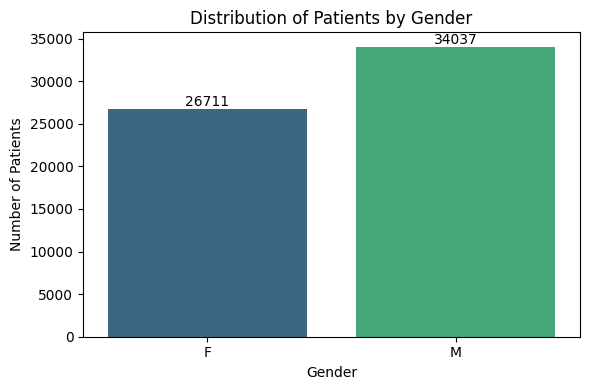


Gender Distribution Data:
  GENDER  count
0      F  26711
1      M  34037


In [16]:
# 1. Define the BigQuery SQL query to get gender counts
query = """
SELECT
    GENDER,
    COUNT(*) AS count
FROM
    `reliable-jet-452114-s2.table.junction_table`
GROUP BY
    GENDER
ORDER BY
    GENDER;
"""

# 2. Execute the query and load results into a Pandas DataFrame
gender_distribution_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not gender_distribution_df.empty:
    plt.figure(figsize=(6, 4)) # Set the figure size
    sns.barplot(x='GENDER', y='count', data=gender_distribution_df, palette='viridis') # Use Seaborn for nicer plotting

    # Add labels and title
    plt.xlabel("Gender")
    plt.ylabel("Number of Patients")
    plt.title("Distribution of Patients by Gender")

    # Add count labels on top of bars
    for index, row in gender_distribution_df.iterrows():
        plt.text(index, row['count'], row['count'], color='black', ha="center", va='bottom')

    # Display the plot
    plt.tight_layout() # Adjust layout
    plt.show()
else:
    print("No data returned from the query to plot.")

# 4. Print the Dataframe
print("\nGender Distribution Data:")
print(gender_distribution_df)

### **Gender Connection with Length of Stay**

<ipython-input-17-024af741439d>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='GENDER', y='ICU_LOS', data=gender_los_df, palette='viridis', showfliers=True)


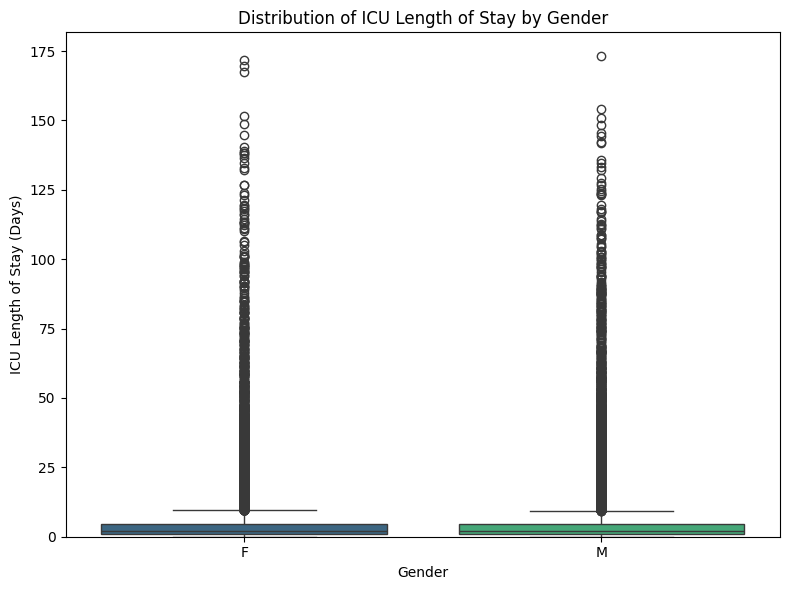


Summary Statistics for ICU LOS by Gender:
          count      mean       std     min      25%     50%      75%  \
GENDER                                                                  
F       26711.0  4.948872  9.835709  0.0001  1.09495  2.1137  4.52885   
M       34037.0  4.885333  9.501022  0.0002  1.11330  2.0738  4.43910   

             max  
GENDER            
F       171.6227  
M       173.0725  


In [17]:
# 1. Define the BigQuery SQL query to get Gender and ICU Length of Stay
#    We select the raw data needed for the box plot.
query = """
SELECT
    GENDER,
    ICU_LOS  -- The numerical variable (Length of Stay)
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ICU_LOS IS NOT NULL -- Ensure LOS is not null for the plot
    AND GENDER IS NOT NULL -- Ensure Gender is not null
    -- Optional: Add a condition to limit LOS range if outliers are extreme
    -- AND ICU_LOS < 60 -- Example: Limit to stays less than 60 days for better visualization
ORDER BY GENDER;
"""

# 2. Execute the query and load results into a Pandas DataFrame
gender_los_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not gender_los_df.empty:
    plt.figure(figsize=(8, 6)) # Adjust figure size if needed

    # Create the box plot
    sns.boxplot(x='GENDER', y='ICU_LOS', data=gender_los_df, palette='viridis', showfliers=True)
    # showfliers=True includes outliers, set to False to hide them if they distort the scale too much

    # Add labels and title
    plt.xlabel("Gender")
    plt.ylabel("ICU Length of Stay (Days)")
    plt.title("Distribution of ICU Length of Stay by Gender")
    plt.ylim(bottom=0) # Ensure y-axis starts at 0

    # Display the plot
    plt.tight_layout() # Adjust layout
    plt.show()

    # Optional: Calculate and print summary statistics
    print("\nSummary Statistics for ICU LOS by Gender:")
    print(gender_los_df.groupby('GENDER')['ICU_LOS'].describe())

else:
    print("No data returned from the query to plot.")

### **Conclusion**
The distributions of patients by gender is fairly simetric, with a slight imbalance for `MALE` (~56.0%).

There is no discernible connection between `Gender` and `Length of Stay`.

### **Age Analysis**

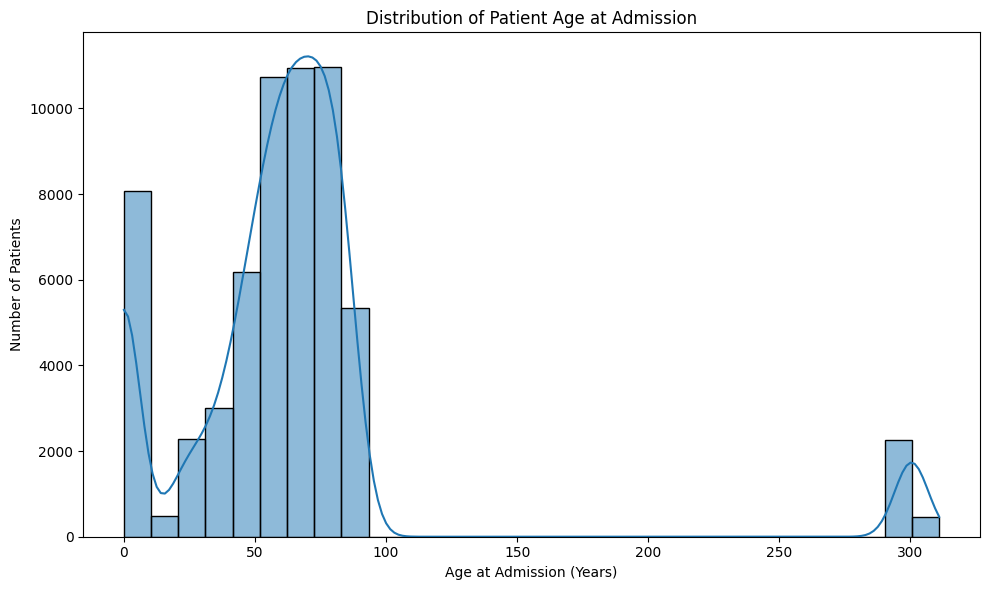


Age at Admission Statistics:
count      60748.0
mean     64.939998
std      57.138132
min            0.0
25%           44.0
50%           62.0
75%           76.0
max          311.0
Name: AGE_AT_ADMISSION, dtype: Float64


In [18]:
# 1. Define the BigQuery SQL query to get the Age at Admission for each row
query = """
SELECT
    AGE_AT_ADMISSION
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    AGE_AT_ADMISSION IS NOT NULL; -- Ensure age is not null
"""

# 2. Execute the query and load results into a Pandas DataFrame
age_distribution_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not age_distribution_df.empty:
    plt.figure(figsize=(10, 6)) # Set the figure size

    # Create a histogram with a Kernel Density Estimate (KDE) overlay
    sns.histplot(data=age_distribution_df, x='AGE_AT_ADMISSION', kde=True, bins=30)
    # 'bins=30' is a starting point, adjust as needed for clarity
    # kde=True adds a smooth line representing the distribution shape

    # Add labels and title
    plt.xlabel("Age at Admission (Years)")
    plt.ylabel("Number of Patients")
    plt.title("Distribution of Patient Age at Admission")

    # Display the plot
    plt.tight_layout() # Adjust layout
    plt.show()
else:
    print("No data returned from the query to plot.")

# 4. Print descriptive statistics for Age
print("\nAge at Admission Statistics:")
print(age_distribution_df['AGE_AT_ADMISSION'].describe())


### **Eliminating rows with Age bigger then 120 years**
Given the histogram results, we decided to eliminate the rows with outliers that most definitely represent input errors, given that there no people near 300 years old.

In [19]:
query = """
CREATE OR REPLACE TABLE `reliable-jet-452114-s2.table.junction_table` AS
SELECT
  * -- Select all columns from the filtered rows
FROM
  `reliable-jet-452114-s2.table.junction_table`
WHERE
  AGE_AT_ADMISSION <= 120; -- Keep only rows where age is 120 or less
"""
query_job = client.query(query)
query_job.result()

In [21]:
table_id = "reliable-jet-452114-s2.table.junction_table"

# Get the table metadata from BigQuery
table = client.get_table(table_id)

# Access the num_rows attribute from the metadata
num_rows = table.num_rows

print(f"The new number of rows in the table is: {num_rows}")

The new number of rows in the table is: 58039


After eliminating these input error mistakes, we ended up with a table containing 58039 rows (~95.5% of the previous table).

### **Age Connection with Length of Stay**

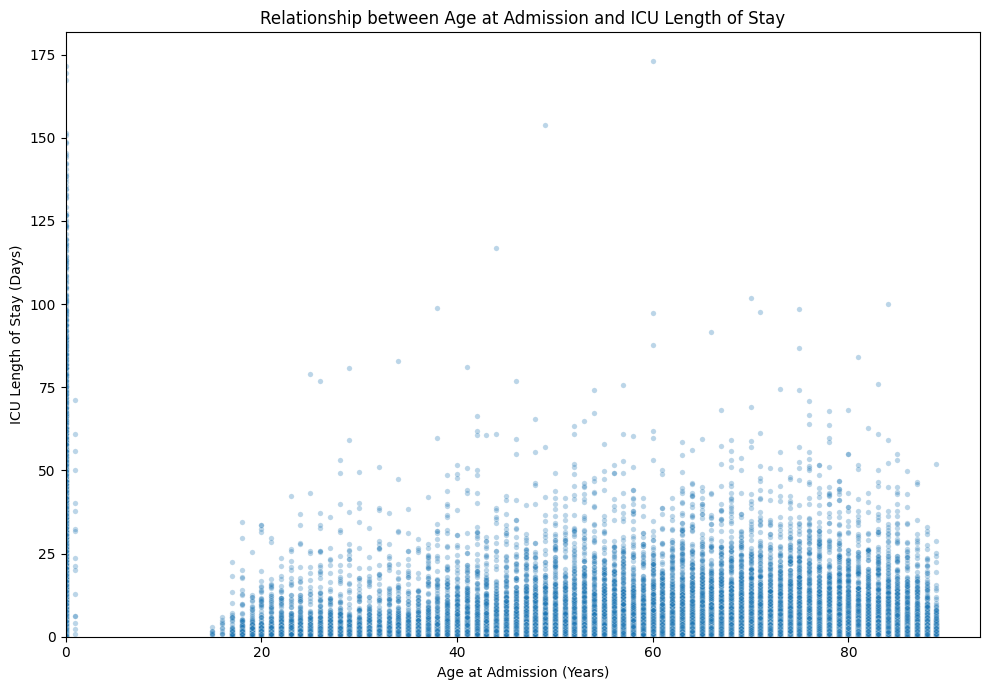


Correlation between Age at Admission and ICU LOS: -0.161


In [22]:
# 1. Define the BigQuery SQL query to get Age and ICU Length of Stay
#    Selecting the raw data needed for the scatter plot.
query = """
SELECT
    AGE_AT_ADMISSION,
    ICU_LOS  -- The other numerical variable (Length of Stay)
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ICU_LOS IS NOT NULL
    AND AGE_AT_ADMISSION IS NOT NULL
    -- Optional: Add conditions to limit ranges if needed for visualization clarity
    -- AND ICU_LOS < 100 -- Example: Limit LOS
    -- AND AGE_AT_ADMISSION > 18 -- Example: Limit Age
"""

# 2. Execute the query and load results into a Pandas DataFrame
age_los_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not age_los_df.empty:
    plt.figure(figsize=(10, 7)) # Adjust figure size

    # Create a scatter plot
    # Use alpha for transparency to handle potential overplotting
    sns.scatterplot(x='AGE_AT_ADMISSION', y='ICU_LOS', data=age_los_df, alpha=0.3, s=15)
    # 's' controls the size of the points
    # 'alpha' controls transparency (lower value = more transparent)

    # Add labels and title
    plt.xlabel("Age at Admission (Years)")
    plt.ylabel("ICU Length of Stay (Days)")
    plt.title("Relationship between Age at Admission and ICU Length of Stay")
    plt.ylim(bottom=0) # Ensure y-axis starts at 0
    plt.xlim(left=0)   # Ensure x-axis starts at 0

    # Display the plot
    plt.tight_layout() # Adjust layout
    plt.show()

    # Calculate correlation
    correlation = age_los_df['AGE_AT_ADMISSION'].corr(age_los_df['ICU_LOS'])
    print(f"\nCorrelation between Age at Admission and ICU LOS: {correlation:.3f}")

else:
    print("No data returned from the query to plot.")

### **Conclusion**
By analysing the histogram of age, we can see that the most common age intervals in the dataset are [0-10] and [50-80].

Regarding the connection between age and length of stay, we can conclude that:
1. The vast majority of ICU stays are relatively short (concentrated roughly below 25 days) across all adult age groups.
2. There isn't a clear, strong linear relationship suggesting that Length of Stay consistently increases or decreases significantly with age. Knowing a patient's age doesn't allow for a precise prediction of their Length of Stay.
3. While short stays are common for all ages, the spread of Length of Stay values appears to widen slightly for older patients, which means that very long stays seem slightly more prevalent among older age groups.